In [32]:
!pip install python-dotenv

In [33]:
%pip install --quiet --upgrade langchain-text-splitters langchain-community langgraph

Note: you may need to restart the kernel to use updated packages.


In [35]:
from dotenv import load_dotenv
import os

load_dotenv()  # This loads variables from .env into environment

# Now you can access them
openai_api_key = os.getenv("OPENAI_API_KEY")
langsmith_api_key = os.getenv("LANGSMITH_API_KEY")

print("Keys loaded successfully!")  # optional

Keys loaded successfully!


In [38]:
pip install -qU "langchain[openai]"

Note: you may need to restart the kernel to use updated packages.


In [40]:
from dotenv import load_dotenv
import os

load_dotenv()  # Loads API keys and env variables from .env

from langchain.chat_models import init_chat_model

llm = init_chat_model("gpt-4o-mini", model_provider="openai")

In [42]:
pip install -qU langchain-openai

Note: you may need to restart the kernel to use updated packages.


In [43]:
from dotenv import load_dotenv
load_dotenv()

from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

In [44]:
pip install -qU langchain-core

Note: you may need to restart the kernel to use updated packages.


In [45]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

In [46]:
!pip install pypdf

In [47]:
pip install langchain langchainhub langchain-community pypdf bs4


Note: you may need to restart the kernel to use updated packages.


In [48]:
# === IMPORTS ===
import requests
import tempfile
import os
import logging
import sys
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document
from langgraph.graph import StateGraph
from typing_extensions import TypedDict, List
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate

# === DISABLE LOGGING ===
logging.getLogger().handlers.clear()
logging.basicConfig(level=logging.CRITICAL)

# === STEP 1: Download PDF ===
pdf_url = "https://github.com/SrujanaSirimala/Ebook/raw/main/A%20World%20is%20Born.pdf"
temp_dir = tempfile.mkdtemp()
pdf_path = os.path.join(temp_dir, "ebook.pdf")
response = requests.get(pdf_url)
with open(pdf_path, "wb") as f:
    f.write(response.content)

# === STEP 2: Load & Chunk PDF ===
loader = PyPDFLoader(pdf_path)
docs = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
all_splits = text_splitter.split_documents(docs)

# === CLEAN TEXT ===
def clean_text(text):
    return text.encode("utf-8", errors="ignore").decode("utf-8")

for doc in all_splits:
    doc.page_content = clean_text(doc.page_content)

# === STEP 3: Embed & Index ===
embedding = OpenAIEmbeddings()
vector_store = FAISS.from_documents(all_splits, embedding)

# === STEP 4: Define Prompt & LLM ===
prompt = ChatPromptTemplate.from_messages([
    ("system", "Answer the question using only the context below."),
    ("human", "Context:\n{context}\n\nQuestion: {question}")
])

llm = ChatOpenAI()

# === STEP 5: State ===
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

# === STEP 6: RAG Steps ===
def retrieve(state: State):
    return {"context": vector_store.similarity_search(state["question"])}

def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    try:
        messages = prompt.invoke({"question": state["question"], "context": docs_content})
        response = llm.invoke(messages)
        return {"answer": response.content}
    except Exception as e:
        return {"answer": f"❌ LLM Error: {str(e)}"}

# === STEP 7: Graph ===
graph_builder = StateGraph(State)
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.set_entry_point("retrieve")
graph_builder.add_edge("retrieve", "generate")
graph = graph_builder.compile()

# === STEP 8: Ask a Question ===
question = "What is the central theme of the story in 'A World is Born'?"
result = graph.invoke({"question": question})

# === STEP 9: Final Output ===
final_answer = result.get("answer", "").strip()
print("\n📘 Final Answer:\n" + final_answer)



📘 Final Answer:
The central theme of the story in "A World is Born" is the tension and conflict between individuals seeking to rebuild and establish a new world against those who are selfish and resentful of the effort.


In [49]:
pip install unstructured[pdf]

In [50]:
pip install pdfminer.six

Note: you may need to restart the kernel to use updated packages.


In [51]:
pip install pymupdf

Note: you may need to restart the kernel to use updated packages.


In [52]:
import fitz  # PyMuPDF
import requests
from io import BytesIO

# URL of the PDF
pdf_url = "https://raw.githubusercontent.com/SrujanaSirimala/Ebook/main/A%20World%20is%20Born.pdf"

# Download the PDF
response = requests.get(pdf_url)
pdf_data = BytesIO(response.content)

# Open the PDF with PyMuPDF (using file-like object)
doc = fitz.open(stream=pdf_data)

# Extract text from each page
text = ""
for page_num in range(doc.page_count):
    page = doc.load_page(page_num)  # Load page
    text += page.get_text("text")  # Extract text

# Print the total number of characters
print(f"Total characters: {len(text)}")

Total characters: 50260


In [53]:
print(docs[0].page_content[:500])

The first ripples of blue fire touched Dio's men. Bolts of it fastened on gun-
butts, and knuckles. Men screamed and fell. Jill cried out as he tore silver or-
naments from her dress. 
 
 
A WORLD IS BORN  
 
By Leigh Brackett 
 
 
 
Ebooks Corporation Limited


In [54]:
pip install --upgrade langchain

Note: you may need to restart the kernel to use updated packages.


In [55]:
# Assuming 'text' contains all the extracted content from the PDF

chunk_size = 1000
chunk_overlap = 200

# Create chunks with overlap
chunks = []
start = 0
while start < len(text):
    end = start + chunk_size
    chunks.append(text[start:end])
    start = end - chunk_overlap

# Print the result
print(f"Split Ebook into {len(chunks)} sub-documents.")

Split Ebook into 63 sub-documents.


In [70]:
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.schema import Document

# Assuming 'text' contains the extracted content from the PDF (string type)

# Define your chunk size and overlap
chunk_size = 1000  # Characters per chunk
chunk_overlap = 200  # Characters to overlap between chunks

# Step 1: Manually split the text into chunks with overlap
chunks = []
start = 0

# Loop through the text and split it into chunks
while start < len(text):
    end = start + chunk_size
    chunk = text[start:end]
    chunks.append(chunk)
    start = end - chunk_overlap  # Move the start position to introduce overlap

# Check how many chunks were created and preview the first chunk
print(f"Number of chunks: {len(chunks)}")
print(f"First chunk preview: {chunks[0][:200]}")  # Preview the first 200 characters

# Step 2: Convert chunks into Document objects
documents = [Document(page_content=chunk) for chunk in chunks]

# Step 3: Generate embeddings for each chunk
embeddings = OpenAIEmbeddings()

# Get embeddings for all documents (note: FAISS will handle this internally when initializing)
vector_store = FAISS.from_documents(documents, embeddings)

# Step 4: Add documents to vector store (this happens internally when calling from_documents)
document_ids = vector_store.add_documents(documents=documents)

# Print the first 3 document IDs added to the vector store
print(f"First 3 document IDs added: {document_ids[:3]}")

Number of chunks: 63
First chunk preview:  
 
The first ripples of blue fire touched Dio's men. Bolts of it fastened on gun-
butts, and knuckles. Men screamed and fell. Jill cried out as he tore silver or-
naments from her dress. 
 
 
A WORLD
First 3 document IDs added: ['3288a7ce-f295-49c1-b34e-9b98b90a873b', '7d38df9a-ae8e-479e-a7c9-1c8ad3259179', 'f08c9486-f755-4709-908f-e00fcc822c79']


In [71]:
# Retrieval and Generation {#orchestration}
from langchain import hub

prompt = hub.pull("rlm/rag-prompt")

example_messages = prompt.invoke(
    {
        "context": "context goes here",
        "question": "question goes here"
    }
).to_messages()

print(example_messages[0].content)

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: question goes here 
Context: context goes here 
Answer:


In [74]:
# To use LangGraph, we need to define three things:

# The state of our application;
# The nodes of our application (i.e., application steps);
# The "control flow" of our application (e.g., the ordering of the steps).

from langchain_core.documents import Document
from typing_extensions import List, TypedDict


class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [76]:
# Nodes (application steps)
def retrieve(state: State):
    retrieved_docs = vector_store.similarity_search(state["question"])
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}

In [78]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence([retrieve, generate])
graph_builder.add_edge(START, "retrieve")
graph = graph_builder.compile()

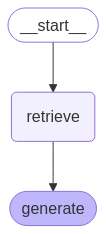

In [80]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))


In [82]:
# Usage
result = graph.invoke({"question": "What is the story about?"})

print(f'Context: {result["context"]}\n\n')
print(f'Answer: {result["answer"]}')

Context: [Document(id='ed5d04ff-bec7-4e14-8133-cb008887baa5', metadata={}, page_content='e looked aside at the stony-faced girl beside him. She was \nstudying him contemptuously out of hard gray eyes. \n"How," she said slowly, "can you be such a callous swine?" \n"Callous?" He controlled the quite unreasonable anger that \nrose in him. "Not at all. The war taught me that if I didn\'t look \nout for myself, no one would." \n"And yet you must have started out a human being." \nHe laughed. \nThe ship burst into searing sunlight. The Sunside of Mercury \nblazed below them. Out toward the velvet dark of space the \nside of a waiting ship flashed burning silver. \nEven as he watched, the flare of its rockets arced against the \nblackness. They had been sighted. \n \n \n18 \n \nGray\'s practised eye gauged the stranger\'s speed against his \nown, and he cursed softly. Abruptly he wheeled the ship and \nstarted down again, cutting his rockets as the shadow swal-\nlowed them. The ship was eeril

In [84]:
# Stream steps:
for step in graph.stream(
    {"question": "What is the story about?"}, stream_mode="updates"
):
    print(f"{step}\n\n----------------\n")

{'retrieve': {'context': [Document(id='ed5d04ff-bec7-4e14-8133-cb008887baa5', metadata={}, page_content='e looked aside at the stony-faced girl beside him. She was \nstudying him contemptuously out of hard gray eyes. \n"How," she said slowly, "can you be such a callous swine?" \n"Callous?" He controlled the quite unreasonable anger that \nrose in him. "Not at all. The war taught me that if I didn\'t look \nout for myself, no one would." \n"And yet you must have started out a human being." \nHe laughed. \nThe ship burst into searing sunlight. The Sunside of Mercury \nblazed below them. Out toward the velvet dark of space the \nside of a waiting ship flashed burning silver. \nEven as he watched, the flare of its rockets arced against the \nblackness. They had been sighted. \n \n \n18 \n \nGray\'s practised eye gauged the stranger\'s speed against his \nown, and he cursed softly. Abruptly he wheeled the ship and \nstarted down again, cutting his rockets as the shadow swal-\nlowed them. Th

In [85]:
for message, metadata in graph.stream(
    {"question": "What is the story about?"}, stream_mode="messages"
):
    print(message.content, end="|")

|The| story| revolves| around| Gray| and| Ward|,| who| are| involved| in| dangerous| and| clandest|ine| situations| on| a| spaceship|.| Gray| appears| to| be| a| survivor| of| war|,| motivated| by| self|-p|reservation|,| while| Ward| seems| to| be| aiding| Gray| in| a| scheme| for| personal| gain|.| Their| interactions| are| filled| with| tension| and| intrigue|,| leading| to| unexpected| twists| and| turns| in| their| journey|.||

In [88]:
from langchain_core.prompts import PromptTemplate

template = """Use the following pieces of context to answer the question at the end.
If you don't know the answer, just say that you don't know, don't try to make up an answer.
Use three sentences maximum and keep the answer as concise as possible.
Always say "thanks for asking!" at the end of the answer.

{context}

Question: {question}

Helpful Answer:"""
custom_rag_prompt = PromptTemplate.from_template(template)

In [90]:
# Check if all_splits is not empty
if len(all_splits) == 0:
    print("all_splits is empty!")
else:
    print(f"all_splits has {len(all_splits)} documents.")


all_splits has 85 documents.


In [92]:
total_documents = len(all_splits)
third = total_documents // 3

for i, document in enumerate(all_splits):
    if i < third:
        document.metadata["section"] = "beginning"
    elif i < 2 * third:
        document.metadata["section"] = "middle"
    else:
        document.metadata["section"] = "end"


all_splits[0].metadata

{'producer': 'Adobe PDF Library 9.0',
 'creator': 'Acrobat PDFMaker 9.0 for Word',
 'creationdate': '2010-07-01T14:20:01+07:00',
 'author': 'kindalat',
 'moddate': '2010-07-19T11:52:40-04:00',
 'sourcemodified': 'D:20100701071952',
 'source': 'C:\\Users\\sruja\\AppData\\Local\\Temp\\tmpxbgu_0we\\ebook.pdf',
 'total_pages': 43,
 'page': 0,
 'page_label': '',
 'section': 'beginning'}

In [94]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)
_ = vector_store.add_documents(all_splits)

In [96]:
from typing import Literal

from typing_extensions import Annotated


class Search(TypedDict):
    """Search query."""

    query: Annotated[str, ..., "Search query to run."]
    section: Annotated[
        Literal["beginning", "middle", "end"],
        ...,
        "Section to query.",
    ]

In [98]:
class State(TypedDict):
    question: str
    query: Search
    context: List[Document]
    answer: str


def analyze_query(state: State):
    structured_llm = llm.with_structured_output(Search)
    query = structured_llm.invoke(state["question"])
    return {"query": query}


def retrieve(state: State):
    query = state["query"]
    retrieved_docs = vector_store.similarity_search(
        query["query"],
        filter=lambda doc: doc.metadata.get("section") == query["section"],
    )
    return {"context": retrieved_docs}


def generate(state: State):
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = prompt.invoke({"question": state["question"], "context": docs_content})
    response = llm.invoke(messages)
    return {"answer": response.content}


graph_builder = StateGraph(State).add_sequence([analyze_query, retrieve, generate])
graph_builder.add_edge(START, "analyze_query")
graph = graph_builder.compile()

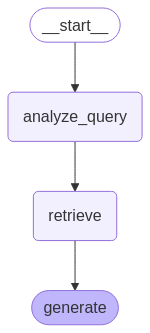

In [100]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
for step in graph.stream(
    {"question": "What happens at the end of the story?"},
    stream_mode="updates",
):
    print(f"{step}\n\n----------------\n")

C:\Users\sruja\anaconda3\Lib\site-packages\langchain_openai\chat_models\base.py:1637: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


{'analyze_query': {'query': {'query': 'end of the story', 'section': 'end'}}}

----------------

